# Github Activity Metrics-Pull Requests

**Activity by Repo**

This notebook will aim to query the Augur DB to access the neccessary information to be able to get the following pull request metrics dirived from the GitHub Community Metrics working document https://docs.google.com/document/d/1Yocr6fk0J8EsVZnJwoIl3kRQaI94tI-XHe7VSMFT0yM/edit?usp=sharing

Any necessary computations from the data to get the metric value will be done as the queries are determined

***Note: There is updates that are needed on the Augur side so this data is not 100% accurate***

In [1]:
import psycopg2
import pandas as pd 
import sqlalchemy as salc
import json
import os
import matplotlib.pyplot as plt
import datetime
plt.rcParams['figure.figsize'] = (15, 5)

with open("../comm_cage.json") as config_file:
    config = json.load(config_file)

In [2]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

In [3]:
#add your repo git url(s) here of the repo(s) you want to query if known (and in the database)
repo_git_set = ['https://github.com/ansible/ansible','https://github.com/pulp/pulp-infra-ansible']
repo_set = []
repo_name_set = []

for repo_git in repo_git_set:
    repo_query = salc.sql.text(f"""
                 SET SCHEMA 'augur_data';
                 SELECT 
                    b.repo_id,
                    b.repo_name
                FROM
                    repo_groups a,
                    repo b
                WHERE
                    a.repo_group_id = b.repo_group_id AND
                    b.repo_git = \'{repo_git}\'
        """)

    t = engine.execute(repo_query)
    results = t.mappings().all()[0]
    repo_id = results['repo_id']
    repo_name = results['repo_name']
    repo_set.append(repo_id)
    repo_name_set.append(repo_name)
print(repo_set)
print(repo_name_set)

[28336, 27515]
['ansible', 'pulp-infra-ansible']


In [4]:
#Take this out of quotes if you want to manually assign a repo_id number(s)
#repo_set = [25440]

## Pull Request Analysis 

### Query for Pull Request Analysis

In [5]:
df_pr = pd.DataFrame()

for repo_id in repo_set: 

    pr_query = salc.sql.text(f"""
                SELECT
                    r.repo_name,
					pr.pull_request_id AS pull_request, 
                    pr.pr_src_number,
					pr.pr_created_at AS created, 
					pr.pr_closed_at AS closed,
					pr.pr_merged_at  AS merged 
                FROM
                	repo r,
                    pull_requests pr
                WHERE
                	r.repo_id = pr.repo_id AND
                    r.repo_id = \'{repo_id}\'
        """)
    df_current_repo = pd.read_sql(pr_query, con=engine)
    df_pr = pd.concat([df_pr, df_current_repo])

df_pr = df_pr.reset_index()
df_pr.drop("index", axis=1, inplace=True)
        
df_pr.head()

,repo_name,pull_request,pr_src_number,created,closed,merged
0,ansible,1759920,695,2012-07-26 10:51:50,2012-07-27 00:15:28,2012-07-27 00:15:28
1,ansible,1759563,3,2012-03-07 17:02:38,2012-03-08 18:38:06,2012-03-08 18:38:06
2,ansible,1759564,16,2012-03-10 21:41:21,2012-03-11 00:51:34,2012-03-11 00:51:34
3,ansible,1759565,25,2012-03-12 23:23:21,2012-03-13 01:08:24,NaT
4,ansible,1759566,28,2012-03-13 03:14:53,2012-03-13 22:35:38,2012-03-13 22:35:38


## Numer of Pull Requests Created

### By Day

In [6]:
two_years = datetime.datetime.now() - datetime.timedelta(days=2*365)
df_pr_daily = df_pr[df_pr['created'] > two_years]

df_pr_daily = df_pr_daily['created'].groupby(df_pr_daily.created.dt.to_period("D")).agg('count')

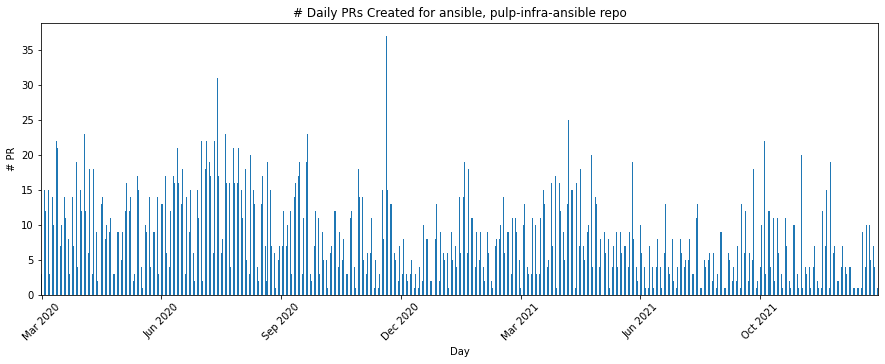

In [7]:
df_pr_daily.plot.bar()

plt.xlabel("Day")
locs, labels = plt.xticks()
N = 90
plt.xticks(locs[::N], df_pr_daily.index[::N].strftime('%b %Y'))
plt.xticks(rotation=45)
plt.ylabel("# PR")
plt.title("# Daily PRs Created for "+', '.join(repo_name_set) +" repo")
plt.show()

### By week

In [8]:
df_pr_weekly = df_pr['created'].groupby(df_pr.created.dt.to_period("W")).agg('count')

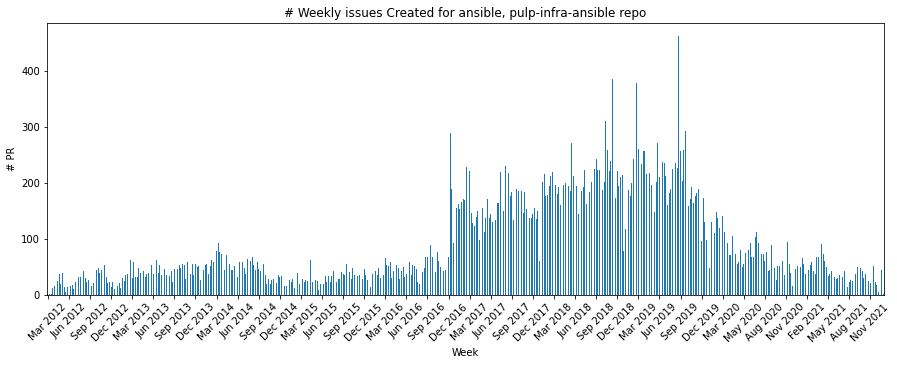

In [9]:
df_pr_weekly.plot.bar()

plt.xlabel("Week")
plt.ylabel("# PR")
locs, labels = plt.xticks()
N = 13
plt.xticks(locs[::N], df_pr_weekly.index[::N].strftime('%b %Y'))
plt.xticks(rotation=45)
plt.title("# Weekly issues Created for "+', '.join(repo_name_set) +" repo")
plt.show()

### By Month

In [10]:
df_pr_monthly = df_pr['created'].groupby(df_pr.created.dt.to_period("M")).agg('count')

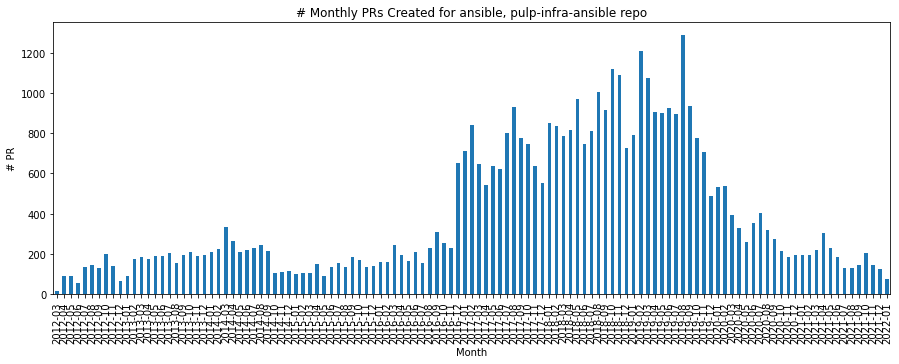

In [11]:
df_pr_monthly.plot.bar()

plt.xlabel("Month")
plt.ylabel("# PR")
plt.title("# Monthly PRs Created for "+', '.join(repo_name_set) +" repo")
plt.show()

## Numer of PRs Merged

### By Day

In [12]:
df_pr_merged_daily = df_pr[df_pr['merged'] > two_years]
df_pr_merged_daily = df_pr_merged_daily['merged'].groupby(df_pr_merged_daily.merged.dt.to_period("D")).agg('count')

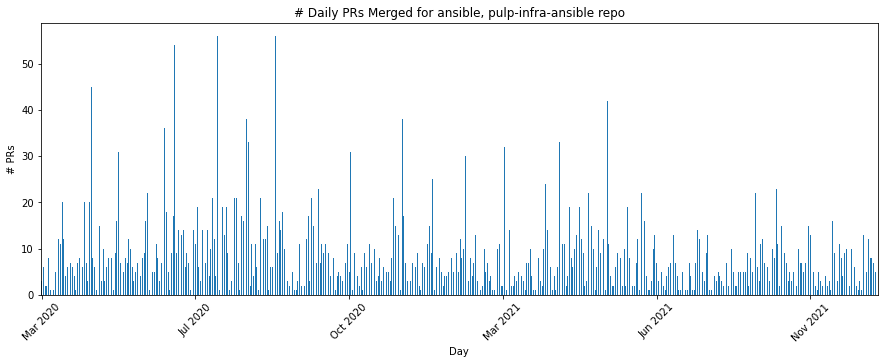

In [13]:
df_pr_merged_daily.plot.bar()

plt.xlabel("Day")
plt.ylabel("# PRs")
locs, labels = plt.xticks()
N = 90
plt.xticks(locs[::N], df_pr_merged_daily.index[::N].strftime('%b %Y'))
plt.xticks(rotation=45)
plt.title("# Daily PRs Merged for "+', '.join(repo_name_set) +" repo")
plt.show()

### By Week

In [14]:
df_pr_merged_weekly = df_pr['merged'].groupby(df_pr.merged.dt.to_period("W")).agg('count')

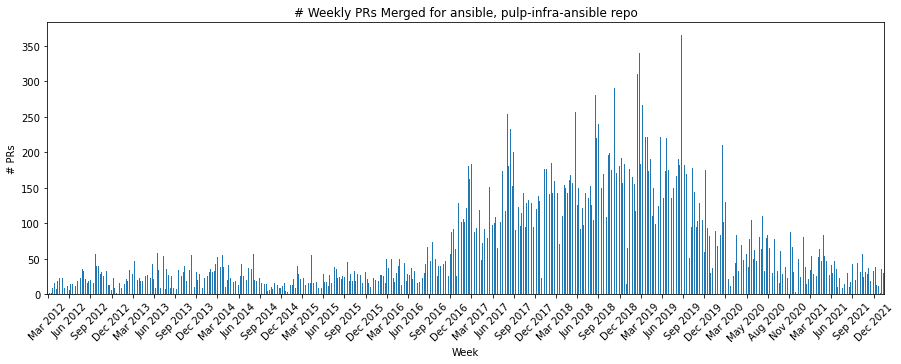

In [15]:
df_pr_merged_weekly.plot.bar()

plt.xlabel("Week")
locs, labels = plt.xticks()
N = 13
plt.xticks(locs[::N], df_pr_merged_weekly.index[::N].strftime('%b %Y'))
plt.xticks(rotation=45)
plt.ylabel("# PRs")
plt.title("# Weekly PRs Merged for "+', '.join(repo_name_set) +" repo")
plt.show()

### By Month

In [16]:
df_pr_merged_monthly = df_pr['merged'].groupby(df_pr.merged.dt.to_period("M")).agg('count')

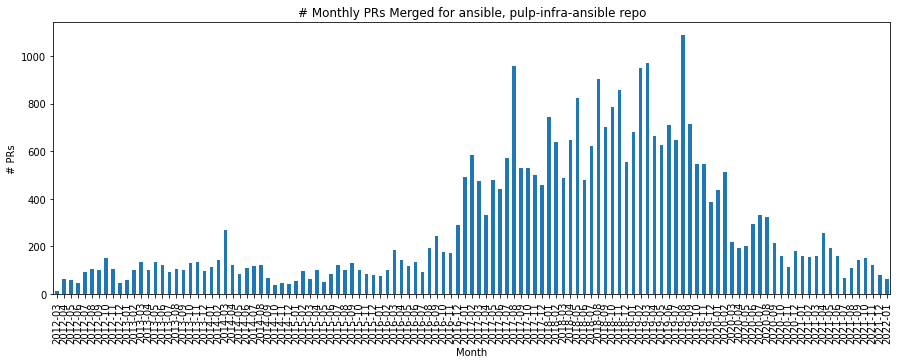

In [17]:
df_pr_merged_monthly.plot.bar()

plt.xlabel("Month")
plt.ylabel("# PRs")
plt.title("# Monthly PRs Merged for "+', '.join(repo_name_set) +" repo")
plt.show()

## Numer of PRs closed 

### By Day

In [18]:
df_pr_closed_daily = df_pr[df_pr['closed'] > two_years]
df_pr_closed_daily = df_pr_closed_daily['closed'].groupby(df_pr_closed_daily.closed.dt.to_period("D")).agg('count')

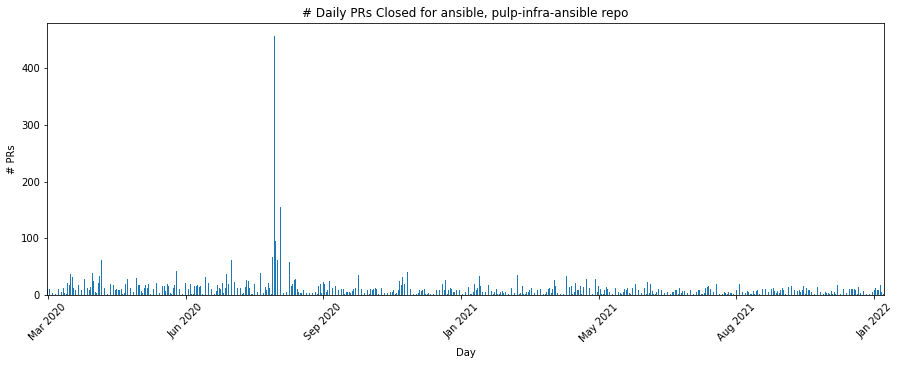

In [19]:
df_pr_closed_daily.plot.bar()

plt.xlabel("Day")
plt.ylabel("# PRs")
locs, labels = plt.xticks()
N = 90
plt.xticks(locs[::N], df_pr_closed_daily.index[::N].strftime('%b %Y'))
plt.xticks(rotation=45)
plt.title("# Daily PRs Closed for "+', '.join(repo_name_set) +" repo")
plt.show()

### By Week

In [20]:
df_pr_closed_weekly = df_pr['closed'].groupby(df_pr.closed.dt.to_period("W")).agg('count')

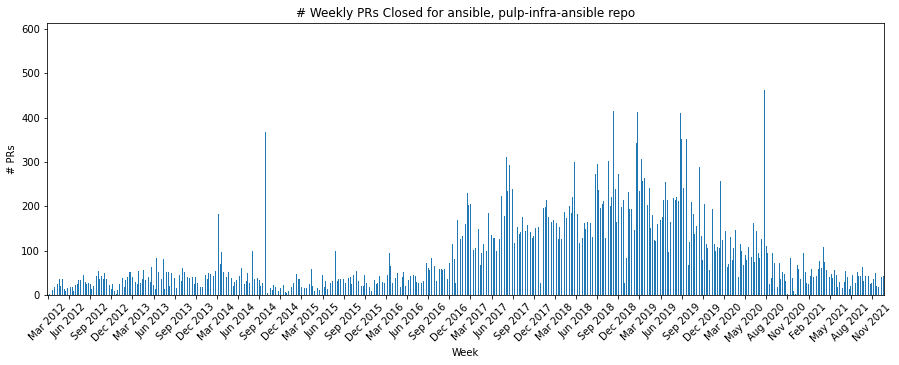

In [21]:
df_pr_closed_weekly.plot.bar()

plt.xlabel("Week")
locs, labels = plt.xticks()
N = 13
plt.xticks(locs[::N], df_pr_closed_weekly.index[::N].strftime('%b %Y'))
plt.xticks(rotation=45)
plt.ylabel("# PRs")
plt.title("# Weekly PRs Closed for "+', '.join(repo_name_set) +" repo")
plt.show()

### By Month

In [22]:
df_pr_closed_monthly = df_pr['closed'].groupby(df_pr.closed.dt.to_period("M")).agg('count')

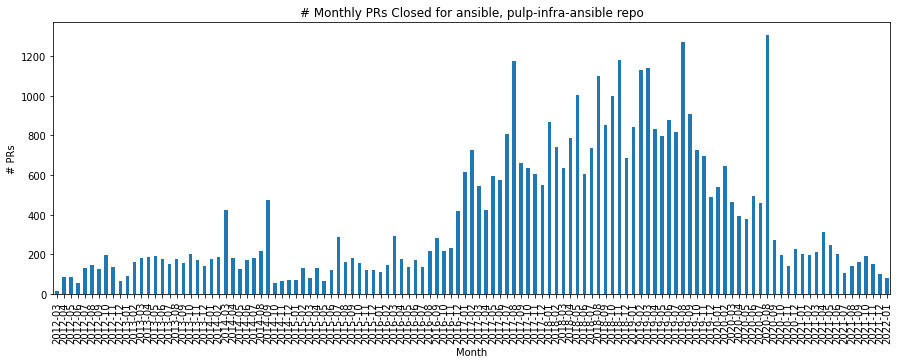

In [23]:
df_pr_closed_monthly.plot.bar()

plt.xlabel("Month")
plt.ylabel("# PRs")
plt.title("# Monthly PRs Closed for "+', '.join(repo_name_set) +" repo")
plt.show()

## Numer of PRs Open over time

In [24]:
df_created = pd.DataFrame(df_pr["created"])
df_created["pr"] = df_created["created"]
df_created['open'] = 1
df_created = df_created.drop(columns="created")

In [25]:
df_closed = pd.DataFrame(df_pr["closed"]).dropna()
df_closed["pr"] = df_closed["closed"]
df_closed['open'] = -1
df_closed = df_closed.drop(columns= "closed")

In [26]:
df_open = pd.concat([df_created, df_closed])
df_open = df_open.sort_values("pr")
df_open = df_open.reset_index(drop=True)
df_open["total"] = df_open["open"].cumsum()
df_open['issue'] = df_open['pr'].dt.floor("D")


In [27]:
df_open = pd.concat([df_created, df_closed])
df_open = df_open.sort_values("pr")
df_open = df_open.reset_index(drop=True)
df_open["total"] = df_open["open"].cumsum()
#df_open['issue'] = df_open['issue'].apply(lambda x: x.replace(hour = 0, minute=0, second=0))
df_open = df_open.drop_duplicates(subset='pr', keep='last')
df_open = df_open.drop(columns= 'open')

### Plot

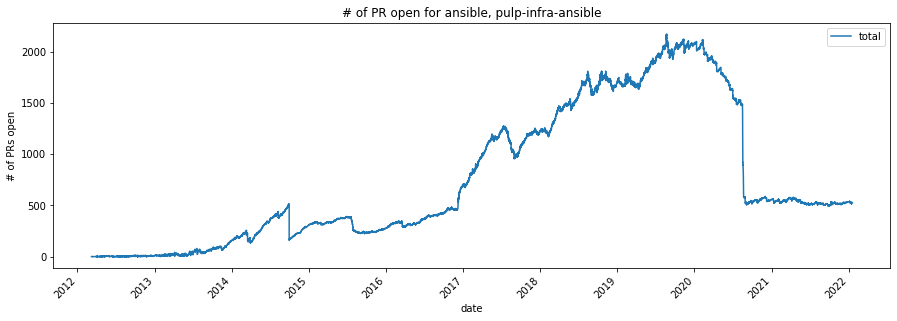

In [28]:
df_open.plot("pr", "total")

plt.xticks(rotation=45)
plt.xlabel("date")
plt.ylabel("# of PRs open")
plt.title("# of PR open for "+', '.join(repo_name_set))
plt.show()